# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

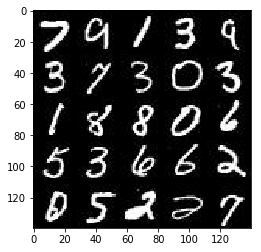

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

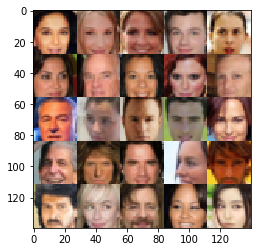

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate= tf.placeholder(tf.float32, name='learn_rate')

    return (inputs_real, inputs_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * x1, x1) # leaky relu
        
        # Output is 14x14x64
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2) # leaky relu
        # Output is 7x7x128
        x3 = tf.layers.conv2d(lrelu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3) # leaky relu
        # Output is 4x4x256
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        dropout = tf.nn.dropout(flat, keep_prob=0.9)
        logits = tf.layers.dense(dropout, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        lrelu1 = tf.nn.dropout(lrelu1, keep_prob=0.5)
        # Output is 7x7x512
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        lrelu2 = tf.nn.dropout(lrelu2, keep_prob=0.5)
        # Output is 7x7x256
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        lrelu3 = tf.nn.dropout(lrelu3, keep_prob=0.5)
        # Ouput is 14x14x128
        x4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        lrelu4 = tf.nn.dropout(lrelu4, keep_prob=0.5)
        # Output is 28x28x64
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=1, padding='same')
        # Output is 28x28x out_channel_dim
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Functions
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * 0.9)) 
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, 
                                                                                  var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(image_width=data_shape[1],
                                             image_height=data_shape[2],
                                             image_channels= data_shape[3],
                                             z_dim=z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    is_train = tf.placeholder(tf.bool)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,
                                               is_train:True})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                              is_train:False})
                
                if steps % 25 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:  
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.9516
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.0022


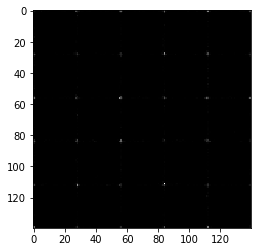

Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.9418


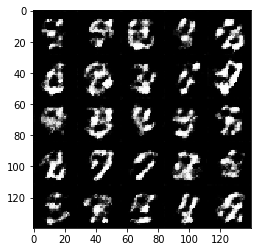

Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.8987


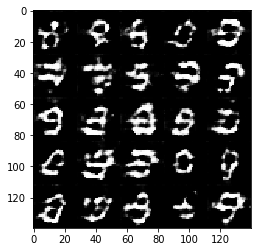

Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.8592


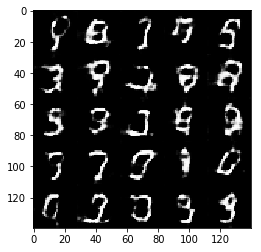

Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.8637


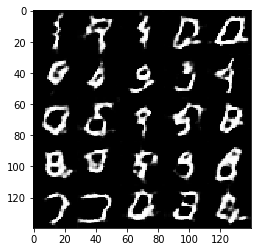

Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.8759


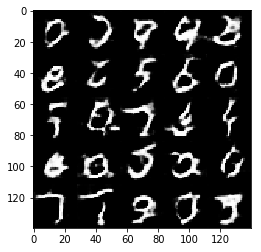

Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.9057


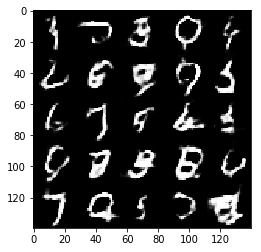

Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.9215
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.9889


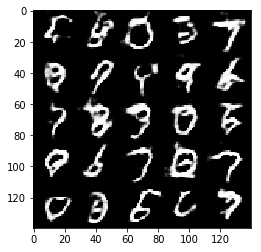

Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.9403
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.9312


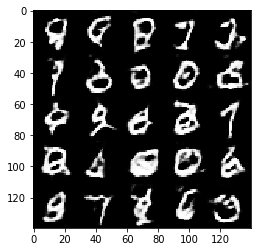

Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7839


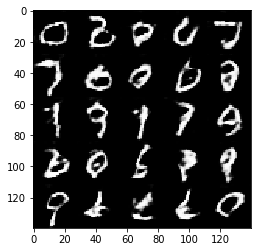

Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 1.0069


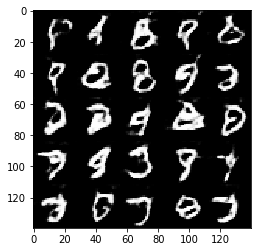

Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 1.0076
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.9044


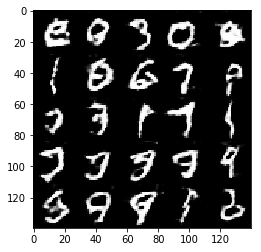

Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.8750


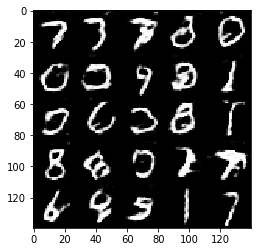

Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 1.1955
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 1.1179
Epoch 2/2... Discriminator Loss: 1.2085... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.0716


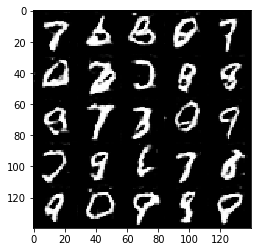

Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.9626


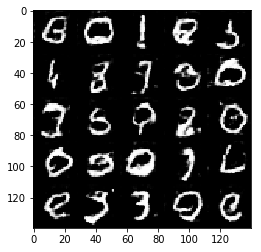

Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.9764


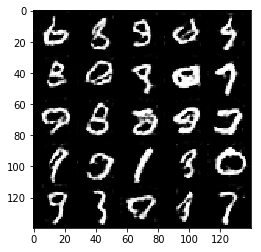

Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8884


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.9345... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.3210


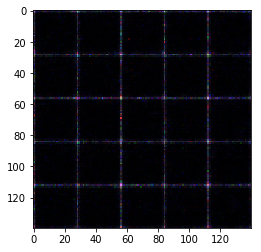

Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.3036


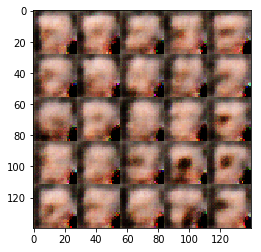

Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.3949


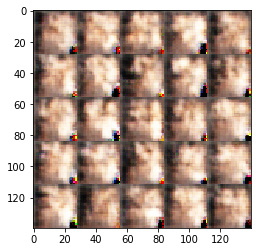

Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.1265


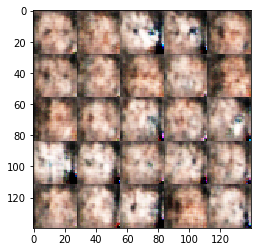

Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.9199


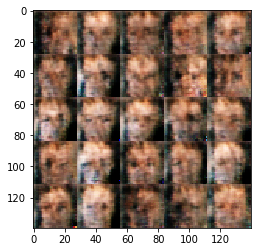

Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 1.0299


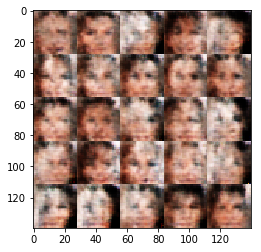

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9344


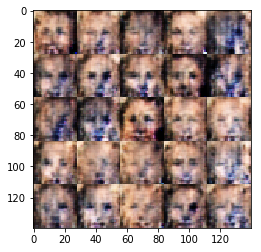

Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.2265


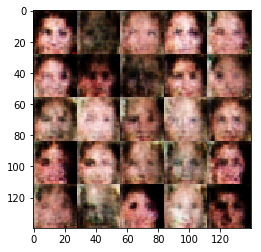

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9151


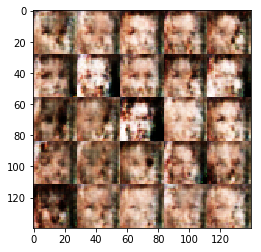

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9206


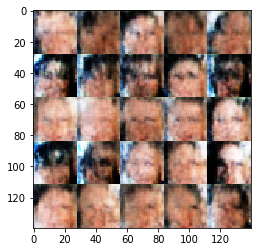

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8894


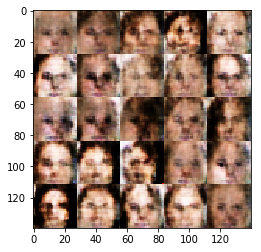

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8920


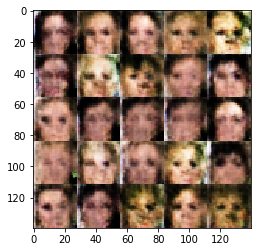

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.9829


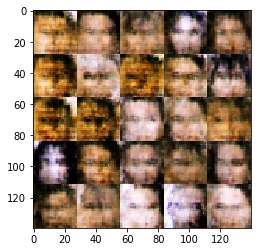

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9101


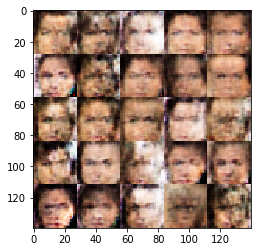

Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.9032


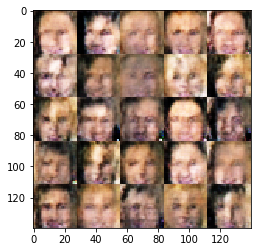

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9298


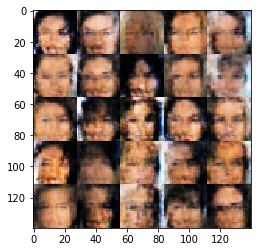

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.9592


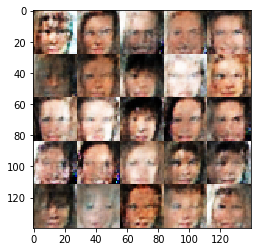

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9060


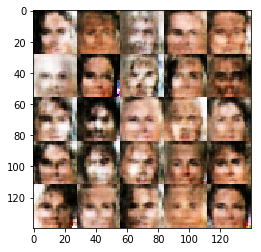

Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8836


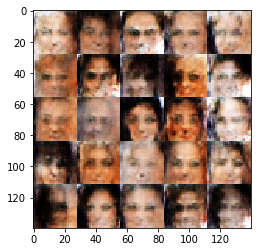

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.9125


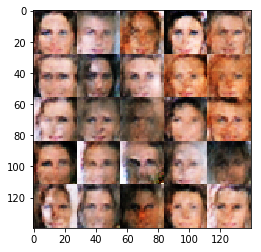

Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.8943


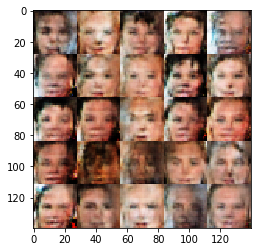

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9865


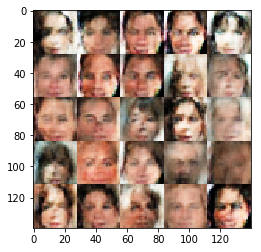

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8983


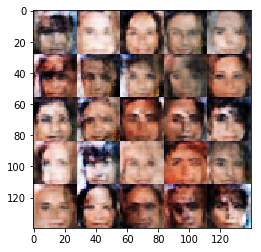

Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9363


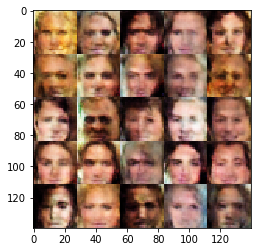

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9032


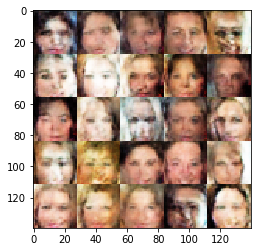

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8849


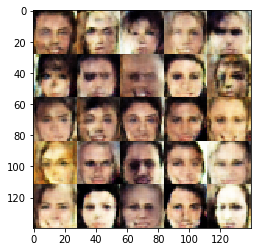

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.8873


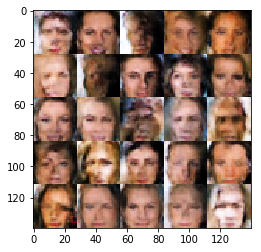

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9451


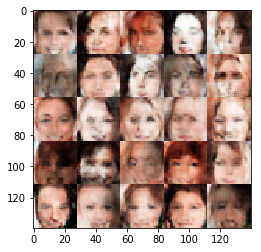

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8320


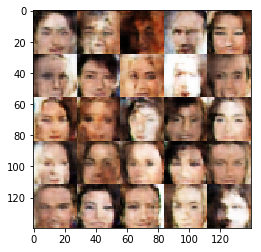

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.9215


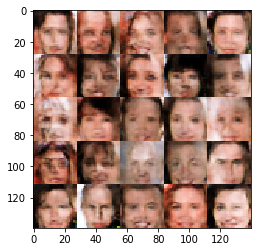

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8759


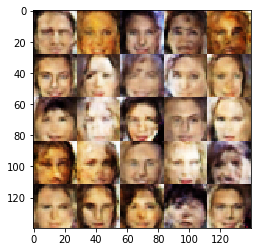

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8031


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.